<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher/blob/main/xpAnalysis_Vit_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ライブラリのインストール

In [3]:
from __future__ import print_function

import glob#glob“はPython標準のライブラリの一つでディレクトリに格納されたファイル名を抽出する
import os#osモジュールは、OSに依存しているさまざまな機能を利用するためのモジュール
import random#randomモジュールは、Pythonでランダムな処理が必要な場合に活躍する標準モジュール
import cv2#画像や動画の処理ができる機能がまとめられたオープンソースライブラリ
# Google Colab環境下ならcv2の代わりにこれを使用する
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np#NumPyは、Pythonに対して型付きの多次元配列オブジェクト (numpy.ndarray) と、その配列に対する多数の演算関数や操作関数を提供
import pandas as pd#pandasは、データ解析を支援する機能を提供するライブラリで、数表および時系列データを操作するためのデータ構造と演算を提供する
import torch#Facebookが開発を主導したPython向けの機械学習ライブラリ
import torch.nn as nn#nnとはneural networkの略
import torch.nn.functional as F#PyTorchでモデル（ネットワーク）を構築・生成するための関数を提供する
import torch.optim as optim#オプティマイザーを提供する
from PIL import Image
from torch.optim.lr_scheduler import StepLR#スケジューラーは学習の過程における学習率の変化を規定する
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms#pytorch_lightningを使用しないのはなぜ？
from tqdm.notebook import tqdm#tqdmは進捗状況や処理状況をプログレスバー（ステータスバー）として表示する機能
#ViTをPytorchで実装したモジュール
from pathlib import Path#pathlibモジュールは、ファイル・ディレクトリのパスを、オブジェクトとして操作できるモジュール
import seaborn as sns#データ可視化のためのライブラリで、複雑なデータをシンプルなコードでグラフ化。Matplotlibと比べて、よりデザイン性の高いグラフを作ることが可能
from pprint import pprint

In [3]:
import shutil
shutil.copytree("/content/drive/MyDrive/xpFile_bbox", "/content/drive/MyDrive/xpFile_bbox_copy")

'/content/drive/MyDrive/xpFile_bbox_copy'

In [4]:
# ディレクトリのパス
base_dir = '/content/drive/MyDrive/xpFile_bbox'

# 対象のディレクトリ内のフォルダ名を取得
folders = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

# 条件に合致するフォルダ名を変更
for folder in folders:
    if len(folder) == 13 and folder[6] == "_":
        new_name = folder[:7] + "20" + folder[7:]
        old_path = os.path.join(base_dir, folder)
        new_path = os.path.join(base_dir, new_name)

        # 実際にリネーム
        os.rename(old_path, new_path)

print("リネームが完了しました。")

リネームが完了しました。


In [7]:
import pandas as pd

# CSVファイルを読み込む
file_path = "/content/drive/MyDrive/XPFiles/xpFilesTable/xpFilesComplete.csv"
df = pd.read_csv(file_path)

# female カラムに基づいてカウント
female_count = df[df['female'] == 1].shape[0]
male_count = df[df['female'] == 0].shape[0]

print(f"女性の人数: {female_count}")
print(f"男性の人数: {male_count}")

女性の人数: 663
男性の人数: 411


In [8]:
# ageカラムの基本統計量を取得
mean_age = df['age'].mean()
std_age = df['age'].std()
median_age = df['age'].median()
q1_age = df['age'].quantile(0.25)
q3_age = df['age'].quantile(0.75)

print(f"年齢の平均値: {mean_age:.2f}")
print(f"年齢の標準偏差: {std_age:.2f}")
print(f"年齢の中央値: {median_age}")
print(f"年齢の第1四分位数: {q1_age}")
print(f"年齢の第3四分位数: {q3_age}")

年齢の平均値: 60.26
年齢の標準偏差: 21.37
年齢の中央値: 65.5
年齢の第1四分位数: 51.0
年齢の第3四分位数: 76.0


In [9]:
# RA カラムに基づいてカウント
ra_count = df[df['RA'] == 1].shape[0]
nonra_count = df[df['RA'] == 0].shape[0]

print(f"関節リウマチの患者(RA)の人数: {ra_count}")
print(f"関節リウマチではない被検者(nonRA)の人数: {nonra_count}")

関節リウマチの患者(RA)の人数: 300
関節リウマチではない被検者(nonRA)の人数: 774


RAの男性の人数: 107
RAの女性の人数: 193
nonRAの男性の人数: 304
nonRAの女性の人数: 470

RAの年齢の平均値: 68.61
RAの年齢の標準偏差: 13.61
RAの年齢の中央値: 70.0
RAの年齢の第1四分位数: 63.0
RAの年齢の第3四分位数: 78.0

nonRAの年齢の平均値: 57.03
nonRAの年齢の標準偏差: 22.91
nonRAの年齢の中央値: 63.0
nonRAの年齢の第1四分位数: 47.25
nonRAの年齢の第3四分位数: 73.75



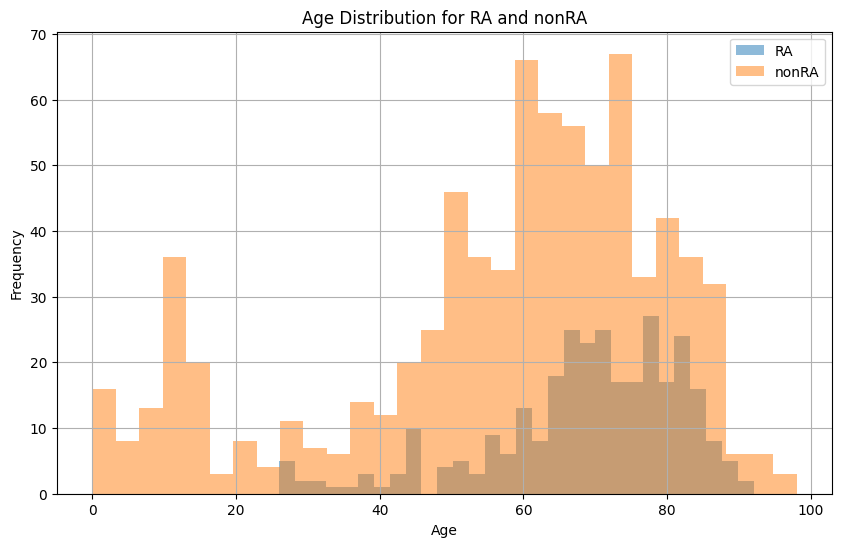

In [10]:
import matplotlib.pyplot as plt

# 1. RAとnonRAの男性と女性の人数をカウント
ra_male = df[(df['RA'] == 1) & (df['female'] == 0)].shape[0]
ra_female = df[(df['RA'] == 1) & (df['female'] == 1)].shape[0]
nonra_male = df[(df['RA'] == 0) & (df['female'] == 0)].shape[0]
nonra_female = df[(df['RA'] == 0) & (df['female'] == 1)].shape[0]

print(f"RAの男性の人数: {ra_male}")
print(f"RAの女性の人数: {ra_female}")
print(f"nonRAの男性の人数: {nonra_male}")
print(f"nonRAの女性の人数: {nonra_female}\n")

# 2. RAとnonRAのageの基本統計量を計算
groups = ["RA", "nonRA"]
for group in groups:
    subset = df[df['RA'] == 1] if group == "RA" else df[df['RA'] == 0]
    print(f"{group}の年齢の平均値: {subset['age'].mean():.2f}")
    print(f"{group}の年齢の標準偏差: {subset['age'].std():.2f}")
    print(f"{group}の年齢の中央値: {subset['age'].median()}")
    print(f"{group}の年齢の第1四分位数: {subset['age'].quantile(0.25)}")
    print(f"{group}の年齢の第3四分位数: {subset['age'].quantile(0.75)}\n")

# 3. RAとnonRAのageのヒストグラムを作成
plt.figure(figsize=(10, 6))
df[df['RA'] == 1]['age'].hist(alpha=0.5, bins=30, label="RA")
df[df['RA'] == 0]['age'].hist(alpha=0.5, bins=30, label="nonRA")
plt.title('Age Distribution for RA and nonRA')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [11]:
import pandas as pd
from scipy.stats import chi2_contingency

# 前のステップで読み込んだdataframeを使用
# RAとnonRAの男女分布を取得
cross_tab = pd.crosstab(df['RA'], df['female'])
print(cross_tab)

# カイ二乗検定を実行
chi2, p, _, _ = chi2_contingency(cross_tab)
print(f"Chi-squared Value: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("男女比に有意な差が存在する")
else:
    print("男女比に有意な差が存在しない")

female    0    1
RA              
0       304  470
1       107  193
Chi-squared Value: 1.044654336757443
P-value: 0.3067414615336914
男女比に有意な差が存在しない


In [12]:
from scipy.stats import ranksums

# RAとnonRAの年齢データを取得
ra_ages = df[df['RA'] == 1]['age'].values
nonra_ages = df[df['RA'] == 0]['age'].values

# Wilcoxonの順位和検定を実行
stat, p = ranksums(ra_ages, nonra_ages)
print(f"Statistic Value: {stat}")
print(f"P-value: {p}")

if p < 0.05:
    print("年齢に有意な差が存在する")
else:
    print("年齢に有意な差が存在しない")

Statistic Value: 7.776201271802201
P-value: 7.473476903226669e-15
年齢に有意な差が存在する


# 学習条件、ランダムシードの設定

In [71]:
# 学習に使用する関節名
EXAMINED_JOINT = "Wrist"  # 実際の関節名に置き換えてください

# 学習パラメータ
epochs = 100  # エポック数
lr = 0.001   # 学習率
gamma = 0.9  # gamma (例: 学習率スケジューラのためのパラメータ等で使われることがあります)
seed = 20    # 乱数シード

print(f"EXAMINED_JOINT: {EXAMINED_JOINT}")
print(f"epochs: {epochs}")
print(f"learning rate: {lr}")
print(f"gamma: {gamma}")
print(f"random seed: {seed}")

EXAMINED_JOINT: Wrist
epochs: 100
learning rate: 0.001
gamma: 0.9
random seed: 20


In [36]:
def seed_everything(seed):#使用するモジュールにおける乱数のシードを統一し、再現性を確保している。
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)#その他さまざまなtorchに含まれる非決定的な計算過程を決定的なものにして再現性を確保している

In [6]:
# GPUの設定
device = 'cuda'

# データセットの前処理

In [37]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # 例えば最大10度のランダムな回転
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 80%から100%の間でランダムに拡大・縮小
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    #transforms.Normalize([0.2573, 0.2573, 0.2573], [0.2369, 0.2369, 0.2369])
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize([0.2573, 0.2573, 0.2573], [0.2369, 0.2369, 0.2369])
])

# データセットのロード

In [7]:
import os
import glob

# xpFilesTable.csv からデータを読み込む
file_path = "/content/drive/MyDrive/XPFiles/xpFilesTable/xpFilesComplete.csv"
df = pd.read_csv(file_path)

# 画像ファイルとそのラベルを保存するリスト
image_paths = []
labels = []
# 各被検者のディレクトリから、指定した関節名に関連する画像データを抽出する
for _, row in df.iterrows():
    # 被検者のディレクトリを取得
    dir_path = os.path.join("/content/drive/MyDrive/xpFile_bbox", row["dir_name_short"], EXAMINED_JOINT)

    # 患者のIDを示す最初の6桁の数字を用いて、関連する画像を検索
    joint_image_files = glob.glob(os.path.join(dir_path, f"{row['dir_name_short'].split('_')[0]}*{EXAMINED_JOINT}*.png"))

    # 画像ファイルのパスとラベルを保存
    image_paths.extend(joint_image_files)
    labels.extend([row["RA"]] * len(joint_image_files))

# 結果の表示
print(f"Total number of images: {len(image_paths)}")
print(f"Number of RA=0 images: {labels.count(0)}")
print(f"Number of RA=1 images: {labels.count(1)}")

Total number of images: 1644
Number of RA=0 images: 1176
Number of RA=1 images: 468


In [ ]:
import shutil
import numpy as np

# ベースディレクトリの作成
base_dir = f"/content/{EXAMINED_JOINT}"
ra_dir = os.path.join(base_dir, "RA")
nonra_dir = os.path.join(base_dir, "nonRA")

# ディレクトリの作成 (存在しない場合)
os.makedirs(ra_dir, exist_ok=True)
os.makedirs(nonra_dir, exist_ok=True)

# 1. 画像をRAおよびnonRAディレクトリに分ける
for img_path, label in zip(image_paths, labels):
    target_dir = ra_dir if label == 1 else nonra_dir
    shutil.copy(img_path, os.path.join(target_dir, os.path.basename(img_path)))

# 2. 各ディレクトリから画像を読み込み、指定された比率で分割する関数
def split_dataset(directory):
    files = glob.glob(os.path.join(directory, "*.png"))  # .jpgを例としています。実際の拡張子に応じて変更してください。

    # ランダムにシャッフル
    np.random.shuffle(files)

    # データの分割
    train_files = files[:int(0.7 * len(files))]
    val_files = files[int(0.7 * len(files)):int(0.9 * len(files))]
    test_files = files[int(0.9 * len(files)):]

    return train_files, val_files, test_files

ra_train, ra_val, ra_test = split_dataset(ra_dir)
nonra_train, nonra_val, nonra_test = split_dataset(nonra_dir)

# 結果の表示
print(f"Number of RA train images: {len(ra_train)}")
print(f"Number of RA validation images: {len(ra_val)}")
print(f"Number of RA test images: {len(ra_test)}")
print(f"Number of nonRA train images: {len(nonra_train)}")
print(f"Number of nonRA validation images: {len(nonra_val)}")
print(f"Number of nonRA test images: {len(nonra_test)}")


In [64]:
from PIL import Image

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# データセットクラスの定義
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
      img_path = self.file_list[idx]
      dir_name = os.path.basename(os.path.dirname(img_path))  # ディレクトリ名を取得
      label = 1 if dir_name == "RA" else 0

      img = Image.open(img_path).convert("RGB")
      if self.transform:
        img = self.transform(img)

      return img, label

# データセットの作成
train_dataset = CustomDataset(ra_train + nonra_train, transform=train_transforms)
val_dataset = CustomDataset(ra_val + nonra_val, transform=val_transforms)
test_dataset = CustomDataset(ra_test + nonra_test, transform=val_transforms)

# DataLoaderの設定
batch_size = 4  # 任意のバッチサイズに設定してください

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoader with resized images has been set up.")

DataLoader with resized images has been set up.


In [65]:
# 各サブセットのサイズを表示
print(f"ra_train size: {len(ra_train)}")
print(f"nonra_train size: {len(nonra_train)}")
print(f"ra_val size: {len(ra_val)}")
print(f"nonra_val size: {len(nonra_val)}")

ra_train size: 163
nonra_train size: 411
ra_val size: 47
nonra_val size: 118


In [66]:
# datasetのサイズを表示
print(f"train_dataset size: {len(train_dataset)}")
print(f"val_dataset size: {len(val_dataset)}")

train_dataset size: 574
val_dataset size: 165


Sample images shape: torch.Size([4, 3, 224, 224])
Sample labels shape: torch.Size([4])
Image values range: 0.0 to 0.9450980424880981


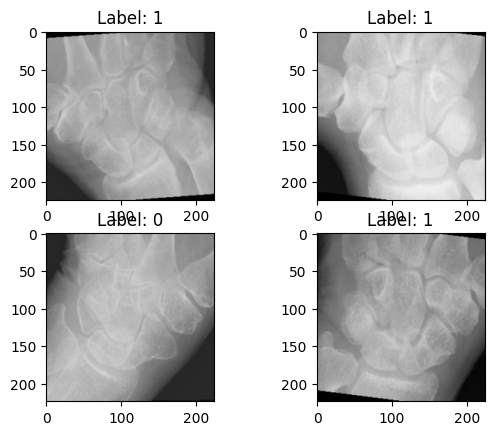

Label distribution in the batch: {0: 1, 1: 3}


In [67]:
# DataLoaderから最初のバッチを取得
sample_images, sample_labels = next(iter(train_loader))

# 画像の形状、ラベルの形状、画像の値の範囲を表示
print(f"Sample images shape: {sample_images.shape}")
print(f"Sample labels shape: {sample_labels.shape}")
print(f"Image values range: {sample_images.min().item()} to {sample_images.max().item()}")

# 最初のバッチからサンプル画像とラベルを表示
for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(2, 2, i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {label.item()}")
    if i == 3:  # 4つのサンプルのみを表示
        break
plt.show()

# バッチ内のラベルの分布を表示
unique, counts = sample_labels.unique(return_counts=True)
print(f"Label distribution in the batch: {dict(zip(unique.tolist(), counts.tolist()))}")


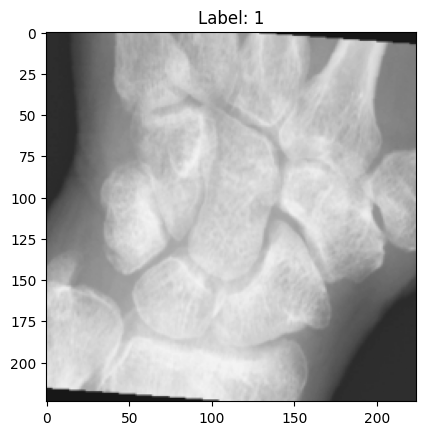

In [45]:
import matplotlib.pyplot as plt

# データローダーから一つのバッチを取得
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 画像を表示する
plt.imshow(images[0].permute(1, 2, 0).numpy()) # CxHxW形式をHxWxC形式に変更
plt.title(f"Label: {labels[0]}")
plt.show()

In [68]:
label_counts = {}
for _, labels in train_loader:
    for label in labels:
        label_counts[label.item()] = label_counts.get(label.item(), 0) + 1

print(label_counts)


{0: 411, 1: 163}


In [47]:
print(f"Train dataset size: {len(train_loader.dataset)}")


Train dataset size: 574


In [69]:
!pip install timm

In [15]:
import timm
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import cv2

# 1. timmを使ってViTモデルをロード
model_name = 'vit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [25]:
model = model.to(device)

In [ ]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

    #ここからが訓練用データの解析
for epoch in range(epochs):#訓練するエポックの数だけループを行う。エポック数は全データセットを何回学習に通すかを示す。
    epoch_loss = 0#各エポックの初めで、エポックのlossをゼロに初期化する。
    epoch_accuracy = 0#各エポックの初めで、エポックのaccuracyをゼロに初期化する。

    for data, label in tqdm(train_loader):#訓練データローダーからバッチを取得する。tqdmはプログレスバーを表示するためのライブラリ。
        data = data.to(device)#取得した画像をGPUに移す（もしCUDAが利用可能なら）。deviceは通常、'cuda'または'cpu'となる。
        label = label.to(device)#取得したラベルをGPUに移す。
        output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
        loss = criterion(output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

        optimizer.zero_grad()#勾配をゼロに初期化する。PyTorchでは勾配が累積されるため、各バッチでゼロにリセットする必要がある。
        loss.backward()#損失関数を用いて求めた損失から、誤差逆伝播法を使用して勾配を計算する。
        optimizer.step()#計算された勾配を用いて、最適化アルゴリズム（ここではAdam）によりモデルのパラメータ（係数と切片）を更新する。

        acc = (output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。argmax関数で、出力から最も確率が高いクラスを選ぶ。それがラベルと一致しているか確認し、平均値を取る。
        epoch_accuracy += acc / len(train_loader)#バッチごとの正確さを加算する。全バッチを通した後、これらの値はエポック全体の平均した正確さになる。
        epoch_loss += loss / len(train_loader)#バッチごとの損失を加算する。全バッチを通した後、これらの値はエポック全体の平均した損失になる。

    #ここからが検証用データの解析
    with torch.no_grad():#勾配の計算を無効にするコンテキストマネージャ。モデルを評価する際には、勾配の計算は不要であり、計算量を削減することができる。
        epoch_val_accuracy = 0#各エポックの初めで、検証したエポックの正確さをゼロに初期化する。
        epoch_val_loss = 0#各エポックの初めで、検証したエポックの損失をゼロに初期化する。
        for data, label in val_loader:#検証データローダーからバッチを取得する。
            data = data.to(device)#取得した画像をGPUに移す
            label = label.to(device)#取得したラベルをGPUに移す
        #以降の部分は基本的に訓練ループと同じ。
        #ただし、検証過程ではモデルのパラメータを更新する必要がないため、optimizer.zero_grad(), loss.backward(), optimizer.step()の部分は含まれていない。
            val_output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
            val_loss = criterion(val_output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

            acc = (val_output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。
            epoch_val_accuracy += acc / len(val_loader)#バッチごとの正確さを加算する。
            epoch_val_loss += val_loss / len(val_loader)#バッチごとの損失を加算する。

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6062 - acc: 0.7153 - val_loss : 0.5956 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.5994 - acc: 0.7153 - val_loss : 0.5932 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.5989 - acc: 0.7170 - val_loss : 0.5932 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6014 - acc: 0.7153 - val_loss : 0.6015 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6029 - acc: 0.7135 - val_loss : 0.6362 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6211 - acc: 0.7049 - val_loss : 0.5992 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6145 - acc: 0.7170 - val_loss : 0.5986 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6464 - acc: 0.7083 - val_loss : 0.5932 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6298 - acc: 0.7014 - val_loss : 0.5947 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6066 - acc: 0.7153 - val_loss : 0.5961 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6145 - acc: 0.7153 - val_loss : 0.6002 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6138 - acc: 0.7083 - val_loss : 0.5943 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6383 - acc: 0.6944 - val_loss : 0.6008 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6007 - acc: 0.7031 - val_loss : 0.5958 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6000 - acc: 0.7170 - val_loss : 0.5938 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6036 - acc: 0.6997 - val_loss : 0.5942 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6013 - acc: 0.7153 - val_loss : 0.5953 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5973 - acc: 0.7170 - val_loss : 0.5932 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6021 - acc: 0.7153 - val_loss : 0.5947 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6004 - acc: 0.7170 - val_loss : 0.5984 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.6015 - acc: 0.7135 - val_loss : 0.5928 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.5974 - acc: 0.7170 - val_loss : 0.5927 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.5992 - acc: 0.7153 - val_loss : 0.5927 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.6004 - acc: 0.7153 - val_loss : 0.5932 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.6188 - acc: 0.6944 - val_loss : 0.5928 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6130 - acc: 0.7153 - val_loss : 0.5929 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.6058 - acc: 0.7135 - val_loss : 0.5930 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.6048 - acc: 0.7170 - val_loss : 0.5937 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.6006 - acc: 0.7170 - val_loss : 0.5988 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.6245 - acc: 0.7014 - val_loss : 0.5995 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.6110 - acc: 0.7101 - val_loss : 0.5928 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.6052 - acc: 0.7153 - val_loss : 0.5994 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.6048 - acc: 0.7153 - val_loss : 0.5928 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.6066 - acc: 0.7153 - val_loss : 0.5974 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.6097 - acc: 0.7153 - val_loss : 0.6002 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.6032 - acc: 0.7153 - val_loss : 0.6025 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.6050 - acc: 0.7170 - val_loss : 0.5965 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.6004 - acc: 0.7153 - val_loss : 0.5931 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.6028 - acc: 0.7170 - val_loss : 0.5927 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.6034 - acc: 0.7153 - val_loss : 0.5931 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.6024 - acc: 0.7153 - val_loss : 0.5961 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.5999 - acc: 0.7153 - val_loss : 0.6255 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.6224 - acc: 0.6962 - val_loss : 0.5946 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.6191 - acc: 0.7170 - val_loss : 0.5970 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.6041 - acc: 0.7170 - val_loss : 0.5984 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.6024 - acc: 0.7170 - val_loss : 0.5936 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.5990 - acc: 0.7153 - val_loss : 0.5927 - val_acc: 0.7202



  0%|          | 0/144 [00:00<?, ?it/s]

In [23]:
input = input.float()

IndentationError: ignored

In [ ]:
input = input.float()

In [ ]:
import os

dir = '/content/drive/MyDrive/xpFilesFinal'
count_file = 0

#ディレクトリの中身分ループ
for file_name in os.listdir(dir):

  #ファイルもしくはディレクトリのパスを取得
  file_path = os.path.join(dir,file_name)

  #ファイルであるか判定
  if os.path.isfile(file_path):
    count_file +=1

print(count_file)

1074


In [ ]:
from sklearn.model_selection import train_test_split

# 画像とCSVファイルのパス
image_dir = "/content/drive/MyDrive/xpFilesFinal"
csv_file_path = "/content/drive/MyDrive/XPFiles/xpFilesTable/xpFilesComplete.csv"

# CSVファイルからデータを読み込み
dataframe = pd.read_csv(csv_file_path)

# 訓練データと検証データに分割
train_df, valid_df = train_test_split(dataframe, test_size=0.2, random_state=seed)

# カスタムデータセットクラス
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
      img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 7]) # file_path columnを使用
      image = Image.open(img_name)
      ra = self.dataframe.iloc[idx, 4] # gender columnを使用
      if ra == '0':
        label = torch.tensor(0, dtype=torch.long)
      else:
        label = torch.tensor(1, dtype=torch.long)
      if self.transform:
        image = self.transform(image)
      return image, label
# 訓練データと検証データのデータセット
train_data = CustomDataset(dataframe=train_df, image_dir=image_dir, transform=train_transforms)
valid_data = CustomDataset(dataframe=valid_df, image_dir=image_dir, transform=val_transforms)

# データローダ
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=64, shuffle=True)

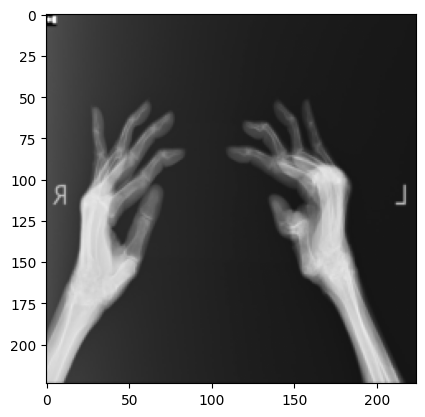

In [ ]:
import matplotlib.pyplot as plt

# DataLoaderからバッチを取得する
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 正規化を逆に適用する関数
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# 画像を表示する関数
def imshow(img):
    img = denormalize(img, [0.2573, 0.2573, 0.2573], [0.2369, 0.2369, 0.2369])
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 一番最初の画像を表示
imshow(images[0])

In [ ]:
# 正規化なしの変換
simple_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# データセットの作成
simple_train_data = CustomDataset(dataframe=train_df, image_dir=image_dir, transform=simple_transforms)

# データローダの作成
simple_train_loader = DataLoader(dataset=simple_train_data, batch_size=64, shuffle=True)

# 平均と標準偏差の計算
mean, std = compute_mean_std(simple_train_loader)
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.2573, 0.2573, 0.2573]), Std: tensor([0.2369, 0.2369, 0.2369])


データをバッチに分ける。

今回バッチサイズは16にするが、メモリが足らない場合は数字をあげる。

In [ ]:
all_labels = list(set(train_labels + valid_labels))

In [ ]:
train_label_counts = {label: train_labels.count(label) for label in all_labels}
valid_label_counts = {label: valid_labels.count(label) for label in all_labels}

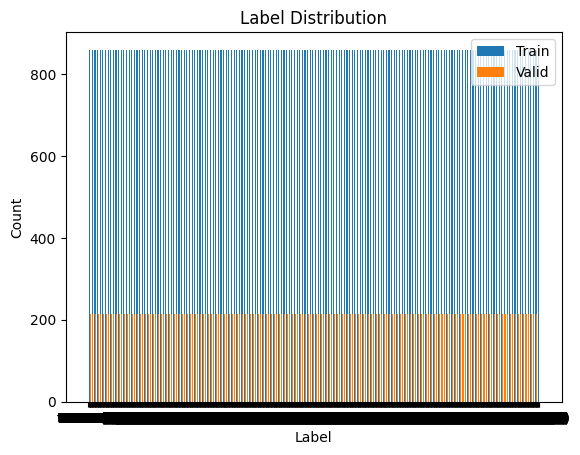

In [ ]:
labels, train_counts = zip(*train_label_counts.items())
_, valid_counts = zip(*valid_label_counts.items())

x = range(len(labels))

plt.bar(x, train_counts, width=0.4, label='Train', align='center')
plt.bar(x, valid_counts, width=0.4, label='Valid', align='edge')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(x, labels)
plt.legend()
plt.title('Label Distribution')
plt.show()

# Vitモデルのロード


In [ ]:
!pip install vit_pytorch timm
from vit_pytorch.efficient import ViT
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [ ]:
model_names = timm.list_models(pretrained=True)
# ファインチューニングしたい場合はpretrained=True
# model_names = timm.list_models(pretrained=True)
#pprint(model_names)

今回は'vit_base_patch16_224_in21k'を選んでみる

In [ ]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
# 訓練済みデータを使用しない場合はpretrained=Falseとする。訓練済みデータを使用し、ファインチューニングしたい場合はpretrained=True
# model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)

# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")

# Vit学習

損失関数、活性化関数の設定をする。

今回はクロスエントロピーロス、アダムを使う。

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()#正常と異常の２値分類であるためクロスエントロピー法を用いる。
# criterion = nn.HuberLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)#パラメーターはデフォルト値を使用する。学習率は上記に定めたものを使用
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

学習ループを設定し、実行していく

In [ ]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
    #ここからが訓練用データの解析
for epoch in range(epochs):#訓練するエポックの数だけループを行う。エポック数は全データセットを何回学習に通すかを示す。
    epoch_loss = 0#各エポックの初めで、エポックのlossをゼロに初期化する。
    epoch_accuracy = 0#各エポックの初めで、エポックのaccuracyをゼロに初期化する。

    for data, label in tqdm(train_loader):#訓練データローダーからバッチを取得する。tqdmはプログレスバーを表示するためのライブラリ。
        data = data.to(device)#取得した画像をGPUに移す（もしCUDAが利用可能なら）。deviceは通常、'cuda'または'cpu'となる。
        label = label.to(device)#取得したラベルをGPUに移す。

        output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
        loss = criterion(output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

        optimizer.zero_grad()#勾配をゼロに初期化する。PyTorchでは勾配が累積されるため、各バッチでゼロにリセットする必要がある。
        loss.backward()#損失関数を用いて求めた損失から、誤差逆伝播法を使用して勾配を計算する。
        optimizer.step()#計算された勾配を用いて、最適化アルゴリズム（ここではAdam）によりモデルのパラメータ（係数と切片）を更新する。

        acc = (output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。argmax関数で、出力から最も確率が高いクラスを選ぶ。それがラベルと一致しているか確認し、平均値を取る。
        epoch_accuracy += acc / len(train_loader)#バッチごとの正確さを加算する。全バッチを通した後、これらの値はエポック全体の平均した正確さになる。
        epoch_loss += loss / len(train_loader)#バッチごとの損失を加算する。全バッチを通した後、これらの値はエポック全体の平均した損失になる。

    #ここからが検証用データの解析
    with torch.no_grad():#勾配の計算を無効にするコンテキストマネージャ。モデルを評価する際には、勾配の計算は不要であり、計算量を削減することができる。
        epoch_val_accuracy = 0#各エポックの初めで、検証したエポックの正確さをゼロに初期化する。
        epoch_val_loss = 0#各エポックの初めで、検証したエポックの損失をゼロに初期化する。
        for data, label in valid_loader:#検証データローダーからバッチを取得する。
            data = data.to(device)#取得した画像をGPUに移す
            label = label.to(device)#取得したラベルをGPUに移す
        #以降の部分は基本的に訓練ループと同じ。
        #ただし、検証過程ではモデルのパラメータを更新する必要がないため、optimizer.zero_grad(), loss.backward(), optimizer.step()の部分は含まれていない。
            val_output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
            val_loss = criterion(val_output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

            acc = (val_output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。
            epoch_val_accuracy += acc / len(valid_loader)#バッチごとの正確さを加算する。
            epoch_val_loss += val_loss / len(valid_loader)#バッチごとの損失を加算する。

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0562 - acc: 0.9609 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/14 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# 学習結果の可視化

<ipython-input-30-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


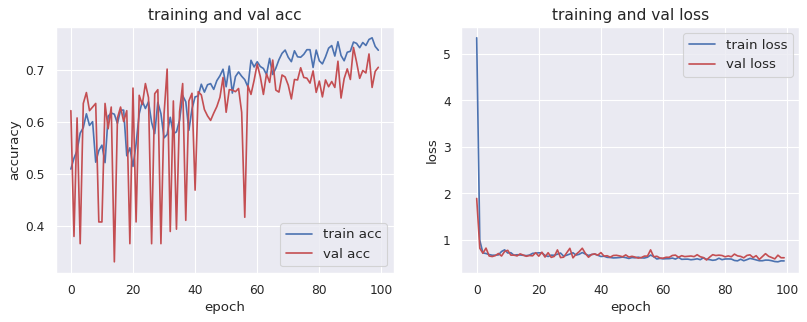

In [ ]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

# 結果と考察

## 結果

- val acc：0.61程度なので精度としては微妙(v1よりは上がった)
- train acc:073程度なので過学習というよりは局所最適解の可能性（v1よりも正解率はは上がった）
- 最低でもval acc:0.7程度無いと希望が持てないレベル

## 考察

- パーの形のみのデータセットにした結果、正解率は上がった。
- 各画像に濃淡差があるので、前処理しても良いかもしれない。
- 他のモデルも検討してみる。（大きな改善は見込めない）